In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

In [3]:
# Create dataset
N = 4096
B = 1024
unique_k_list = [1,0.5,0.25]
data = StepFunctionEventsDatasetFixedTime(N, unique_k_list)
loader = DataLoader(data, batch_size=B, shuffle=True, num_workers=4, collate_fn=padding_collate_fn)

In [4]:
# Create NN model
num_freqs = 6
num_latent = 20
E_bins = 1
encoding = PositionalEncoding()
model = AutoencoderRNN(num_latent, encoding, hidden_size=256, E_bins=E_bins, lam_TV=1, lam_latent=0.1)
trainer = pl.Trainer(max_epochs=100, 
                     accelerator=device, 
                     devices=1, 
                     plugins=[DisabledSLURMEnvironment(auto_requeue=False)], 
                     log_every_n_steps=2)
history = trainer.fit(model, loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /nobackup/users/yankeson/ppae/lightning_logs/version_365690/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | code           | PositionalEncoding | 0     
1 | encoder_lstm   | LSTM               | 278 K 
2 | encoder_linear | Linear             | 5.1 K 
3 | decoder        | ResnetFC           | 27.2 K
------------------------------------------------------
310 K     Trainable params
0         Non-trainable params
310 K     Total params
1.243     Total estimated model par

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [7]:
# Test data, currently just the training data
test_loader = DataLoader(data, batch_size=N, collate_fn=padding_collate_fn)
test_batch = next(iter(test_loader))
model.eval()
model.to(device)
with torch.no_grad():
    model.encode(model.code(test_batch['event_list'].to(device)))
    z = model.latent.cpu().numpy()

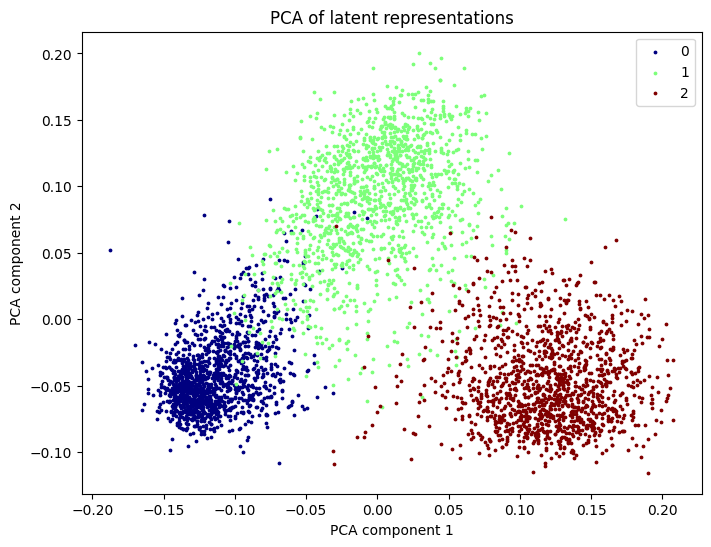

In [10]:
##### PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding = pca.fit_transform(z)

labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.scatter(embedding[idx, 0], embedding[idx, 1], color=colors[i], label=label, marker='o',s=3)

plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend(loc='best')
plt.title('PCA of latent representations')
plt.show()

Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 4096
Input similarities computed in 0.77 seconds (sparsity = 0.030320)!
Learning embedding...
Iteration 50: error is 86.449125 (50 iterations in 2.05 seconds)
Iteration 100: error is 75.345143 (50 iterations in 2.03 seconds)
Iteration 150: error is 74.717379 (50 iterations in 1.96 seconds)
Iteration 200: error is 74.577926 (50 iterations in 1.99 seconds)
Iteration 250: error is 3.725798 (50 iterations in 2.03 seconds)
Iteration 300: error is 2.393666 (50 iterations in 1.63 seconds)
Iteration 350: error is 2.059998 (50 iterations in 1.57 seconds)
Iteration 400: error is 1.894255 (50 iterations in 1.60 seconds)
Iteration 450: error is 1.793810 (50 iterations in 1.62 seconds)
Iteration 500: error is 1.730440 (50 iterations in 1.62 seconds)
Iteration 550: error is 1.692143 (50 iterations in 1.64 seconds)
Iteration 600: error is 

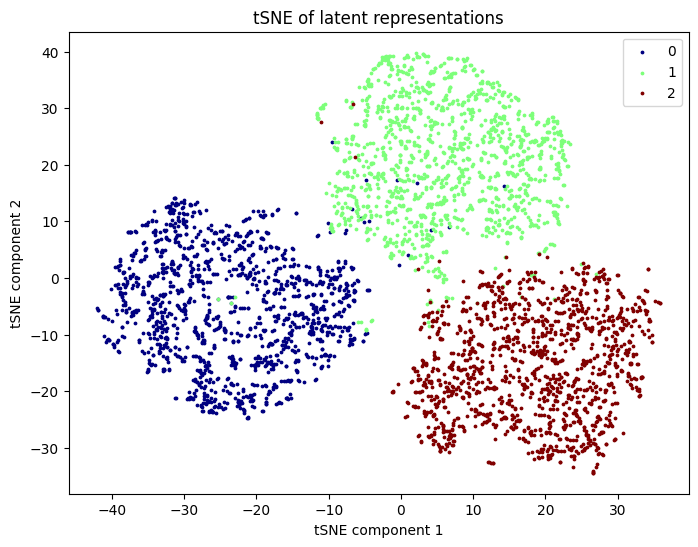

In [11]:
##### t-SNE
from bhtsne import tsne
data_nd_tsne = tsne(z.astype(np.float64))

labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.scatter(data_nd_tsne[idx, 0], data_nd_tsne[idx, 1], color=colors[i], label=label, marker='o',s=3)

plt.xlabel('tSNE component 1')
plt.ylabel('tSNE component 2')
plt.legend(loc='best')
plt.title('tSNE of latent representations')
plt.show()

[[ 0.02079054 -0.11669913  0.20710415 ... -0.00918659 -0.17381622
  -0.14004776]
 [-0.00905238  0.02852642  0.07981211 ... -0.00573332 -0.04831192
   0.01948218]
 [-0.00579978  0.04843199  0.05225015 ...  0.02431977 -0.06280085
   0.02724184]
 ...
 [ 0.03787725 -0.03982778  0.01007482 ... -0.01616326  0.01548815
  -0.00496866]
 [ 0.0277419  -0.02527534  0.04988134 ... -0.02570176 -0.00723541
   0.0009295 ]
 [ 0.03477623 -0.00346068  0.02951998 ...  0.00280008  0.02310224
   0.03975421]]


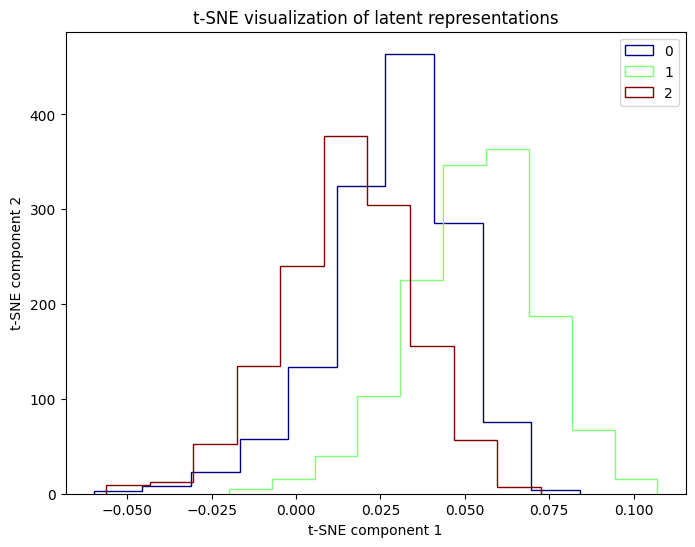

In [12]:
labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
print(z)
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.hist(z[idx, 3], color=colors[i], histtype='step', label=label)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(loc='best')
plt.title('t-SNE visualization of latent representations')
plt.show()

In [13]:
# Visualize the rate function that the NN has learned.
with torch.no_grad():
    coded = model.code(test_batch['event_list'].to(device))
    rates = model.decode(coded[:,:,:-E_bins])
    coded = coded.cpu()
    rates = rates.cpu()
    
# Calculate true rates
labels = test_batch['type'].numpy()
k_list = torch.tensor([1,0.5,0.25])[labels].unsqueeze(-1)
true_rates = 10 + 20 / k_list * (coded[:,:,0] >= 1) * (coded[:,:,0] <= (1+k_list))



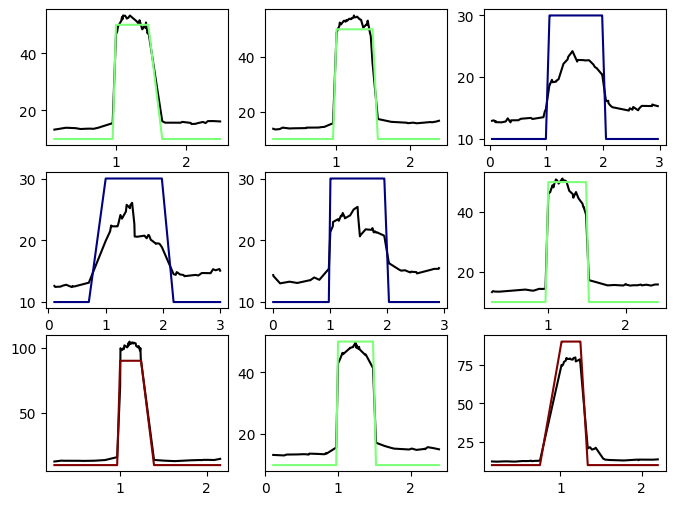

In [14]:
masks = test_batch['mask']
plt.figure(figsize=(8,6))
for i in range(9):
    index = i + 10
    plt.subplot(3,3,i+1)
    plt.plot(coded[index,masks[index],0], torch.exp(rates[index,masks[index],0]),color='k')
    plt.plot(coded[index,masks[index],0], true_rates[index,masks[index]], color = colors[labels[index]])